## Desafío - Regresión desde la econometría

* Para poder realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el .zip

### Contexto

En este desafío trabajaremos con un registro de clientes de un banco e información sobre su salud
financiera. La base contenida en el csv Credit contiene las siguientes variables:

* Income : Ingreso anual disponible en miles de dólares.
* Limit : Límite del crédito.
* Rating : Ranking del crédito.
* Cards : Cantidad de tarjetas de credito.
* Age : Edad del usuario.
* Education : Años de educación del usuario.
* Gender : ¿Hombre o mujer?
* Student : ¿Es estudiante?
* Married : ¿Está casado?
* Ethnicity : Etnicidad del usuario (Caucásico, Afroamericano, Asiático)
* Balance : Promedio de deuda en tarjeta de crédito de usuario.

Para efectos prácticos del desafío, nos interesa saber sobre los determinantes de la variación en el
promedio de deuda en tarjeta de crédito.

A lo largo del desafío generaremos modelos econométricos para inspeccionar los efectos de
distintos atributos


### Desafío 1: Prepare el ambiente de trabajo

* Importe las librerías básicas para el análisis de datos.
* Incluya los import base de statsmodels .
* Importe la base de datos Credit.csv y elimine la columna Unnamed: 0 .
* Siguiendo las buenas prácticas, genere variables binarias para capturar el efecto del grupo minoritario en cada variable. Para el caso de Ethnicity, genere binarias para AfricanAmerican y Asian.
    * tip: Utilice value_counts() para revisar la cantidad de casos en las variables categóricas.

In [20]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [84]:
df = pd.read_csv('Credit.csv')
df.drop(df.columns[0], axis = 1, inplace = True)
df.head(5)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [23]:
df['Gender'].value_counts()

Female    207
 Male     193
Name: Gender, dtype: int64

In [24]:
df['Student'].value_counts()

No     360
Yes     40
Name: Student, dtype: int64

In [25]:
df['Married'].value_counts()

Yes    245
No     155
Name: Married, dtype: int64

In [26]:
df['Ethnicity'].value_counts()

Caucasian           199
Asian               102
African American     99
Name: Ethnicity, dtype: int64

In [85]:
df_final = pd.get_dummies(df).drop(['Gender_Female', 'Married_Yes', 'Student_No', 'Ethnicity_Caucasian'], axis = 1)
df_final.rename(columns = {'Gender_ Male':'Gender_Male', 'Ethnicity_African American': 'Ethnicity_African_American' }, inplace = True)
df_final.head(5)

,Income,Limit,Rating,Cards,Age,Education,Balance,Gender_Male,Student_Yes,Married_No,Ethnicity_African_American,Ethnicity_Asian
0,14.891,3606,283,2,34,11,333,1,0,0,0,0
1,106.025,6645,483,3,82,15,903,0,1,0,0,1
2,104.593,7075,514,4,71,11,580,1,0,1,0,1
3,148.924,9504,681,3,36,11,964,0,0,1,0,1
4,55.882,4897,357,2,68,16,331,1,0,0,0,0


### Desafío 2: Genere gráficos descriptivos para las variables contínuas

* Genere una función llamada plot_hist que genere un histograma de la variable e indique la media y mediana de la misma. Agrege una legenda para indicar qué representa cada línea.
* ¿Cuál es el comportamiento de Balance , Income , Cards y Rating ?

In [74]:
# Vemos las variables continuas
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
Income                        400 non-null float64
Limit                         400 non-null int64
Rating                        400 non-null int64
Cards                         400 non-null int64
Age                           400 non-null int64
Education                     400 non-null int64
Balance                       400 non-null int64
Gender_Male                   400 non-null uint8
Student_Yes                   400 non-null uint8
Married_No                    400 non-null uint8
Ethnicity_African_American    400 non-null uint8
Ethnicity_Asian               400 non-null uint8
dtypes: float64(1), int64(6), uint8(5)
memory usage: 23.9 KB


In [75]:
def plot_hist(dataframe, variable):
    sns.distplot(dataframe[variable])
    plt.axvline(dataframe[variable].mean(), color='tomato', label='Mean')
    plt.axvline(dataframe[variable].median(), color='black', label='Median')
    plt.legend()
    plt.show()

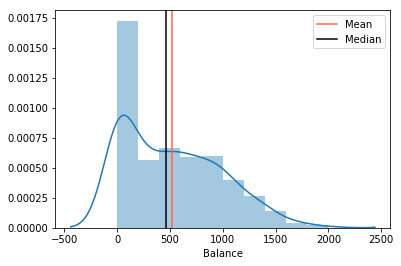

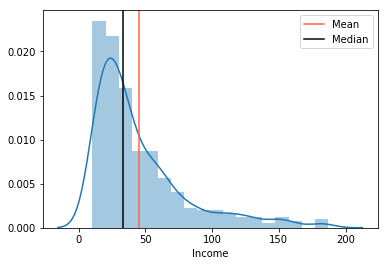

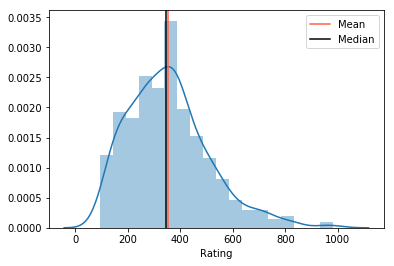

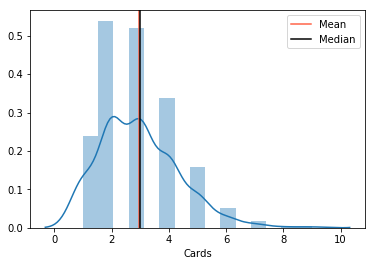

In [76]:
for col in ['Balance', 'Income', 'Rating', 'Cards']:
    plot_hist(df_final, col)

- **Balance**: hay muchas personas con poco balance, lo que hace que la curva se cargue mucho a la izquierda. En general mientras más balance, menos personas.
- **Income**: similar a lo anterior, más ingreso, menor cantidad de personas con dicho ingreso. La mediana es muy diferente a la media. Se puede ver que es más logarítmica.
- **Rating**: el histograma calza mejor con la curva normal y la media es similar a la mediana. LA distribución se ve normal.
- **Cards**: en realidad aquí Cards es categórica, pero la mediana calza con la media (3 tarjetas). A pesar de ser discreta, se ve normalizada.

### Desafío 3: Regresión Lineal Simple

* A continuación generaremos una serie de modelos simples:


$${Balance}={{\beta }_{0} + {\beta }_{1} \cdot {Student} +{\epsilon}_{i}}$$

$${Balance}={{\beta }_{0} + {\beta }_{1} \cdot {Income} +{\epsilon}_{i}}$$

$${Balance}={{\beta }_{0} + {\beta }_{1} \cdot {Rating} +{\epsilon}_{i}}$$



* Utilizando statsmodels , comente brevemente los siguientes puntos:
    * ¿Qué variable presenta un mayor poder explicativo de la variabilidad de Balance ?
    * ¿Qué podemos decir sobre el comportamiento de Student ?
        * ¿Qué pasa si aplicamos una prueba de hipótesis para muestras independientes de Balance entre aquellos que son y no son estudiantes?



In [109]:
model1 = smf.ols('Balance ~ Student_Yes', data = df_final).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     28.62
Date:                Mon, 01 Jul 2019   Prob (F-statistic):           1.49e-07
Time:                        21:55:47   Log-Likelihood:                -3005.5
No. Observations:                 400   AIC:                             6015.
Df Residuals:                     398   BIC:                             6023.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     480.3694     23.434     20.499      0.000     434.300     526.439
Student_Yes   396.4556     74.104      5.350      0.000     250.771     542.140
==============================================================================
Omnibus:                       20.866   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.920
Skew:                           0.544   Prob(JB):                     1.74e-05
Kurtosis:                       2.637   Cond. No.                         3.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
model2 = smf.ols('Balance ~ Income', data = df_final).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     109.0
Date:                Mon, 01 Jul 2019   Prob (F-statistic):           1.03e-22
Time:                        21:08:28   Log-Likelihood:                -2970.9
No. Observations:                 400   AIC:                             5946.
Df Residuals:                     398   BIC:                             5954.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    246.5148     33.199      7.425      0.000     181.247     311.783
Income         6.0484      0.579     10.440      0.000       4.909       7.187
==============================================================================
Omnibus:                       42.505   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.975
Skew:                           0.384   Prob(JB):                     2.79e-05
Kurtosis:                       2.182   Cond. No.                         93.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
model3 = smf.ols('Balance ~ Rating', data = df_final).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     1168.
Date:                Mon, 01 Jul 2019   Prob (F-statistic):          1.90e-120
Time:                        21:08:28   Log-Likelihood:                -2745.4
No. Observations:                 400   AIC:                             5495.
Df Residuals:                     398   BIC:                             5503.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -390.8463     29.069    -13.446      0.000    -447.993    -333.699
Rating         2.5662      0.075     34.176      0.000       2.419       2.714
==============================================================================
Omnibus:                       23.223   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.802
Skew:                           0.390   Prob(JB):                     3.75e-09
Kurtosis:                       4.311   Cond. No.                         970.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- La variable con mayor poder explicativo es el **Rating** con ~75% 😮
- ¿Qué pasa con **Student**? Bueno, tiene un poder explicativo MUY bajo sobre el Balance (explica la variabilidad de `Balance` en un ~7%)

Primero veamos el gráfico de cajas entre ambas variables:

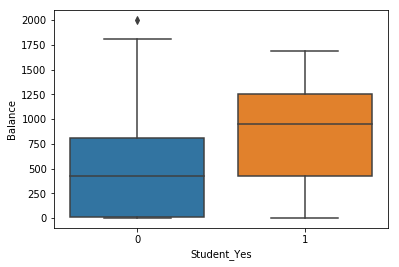

In [111]:
sns.boxplot(x=df_final['Student_Yes'], y=df_final['Balance']);

Ok, aquí podemos ver que:

- el rango de los que no son estudiantes es mayor
- la mediana de los que sí son estudiantes se situana en valores más altos



### Desafío 4: Genere un modelo que incluya todos los regresores

* Comente brevemente sobre el poder explicativo en la varianza de Y las principales características de los predictores.


In [83]:
model_all = smf.ols('Balance ~ Income + Limit + Rating + Cards + Age + Education + Student_Yes + Married_No + Ethnicity_African_American + Ethnicity_Asian + Gender_Male', data = df_final).fit()
model_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     750.3
Date:                Mon, 01 Jul 2019   Prob (F-statistic):          1.11e-253
Time:                        21:08:56   Log-Likelihood:                -2398.7
No. Observations:                 400   AIC:                             4821.
Df Residuals:                     388   BIC:                             4869.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   -488.2880     34.816    -14.025      0.000    -556.740    -419.836
Income                        -7.8031      0.234    -33.314      0.000      -8.264      -7.343
Limit                          0.1909      0.033      5.824      0.000       0.126       0.255
Rating                         1.1365      0.491      2.315      0.021       0.171       2.102
Cards                         17.7245      4.341      4.083      0.000       9.190      26.259
Age                           -0.6139      0.294     -2.088      0.037      -1.192      -0.036
Education                     -1.0989      1.598     -0.688      0.492      -4.241       2.043
Student_Yes                  425.7474     16.723     25.459      0.000     392.869     458.626
Married_No                     8.5339     10.363      0.824      0.411     -11.841      28.908
Ethnicity_African_American   -10.1070     12.210     -0.828      0.408     -34.113      13.899
Ethnicity_Asian                6.6972     12.122      0.552      0.581     -17.137      30.531
Gender_Male                   10.6532      9.914      1.075      0.283      -8.839      30.145
==============================================================================
Omnibus:                       34.899   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.766
Skew:                           0.782   Prob(JB):                     8.52e-10
Kurtosis:                       3.241   Cond. No.                     3.74e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Viendo los valores P de cada intercepto, podemos decir que para la estimación de los coeficientes `Income` , `Limit`, `Rating`, `Cards`, `Age`, `Student_Yes` es significativa al 95% (el valor p es menor a 0.05)

Para el resto de los atributos, no podemos rechazar la hipótesis nula de que al menos uno de los dos sea igual a 0.

### Desafío 5: Depure el modelo e incluya sólo los predictores significativo

* En base al modelo anterior, refactorize e incluya sólo las variables con un nivel de significancia p-value <= 0.025. Comente brevemente sobre el poder explicativo en la varianza de Y las principales características de los predictores.
* ¿Mejoró o empeoró el modelo con la reducción de regresores?


In [88]:
model5 = smf.ols('Balance ~ Income + Limit + Rating + Cards + Student_Yes', data = df_final).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     1640.
Date:                Mon, 01 Jul 2019   Prob (F-statistic):          3.60e-261
Time:                        21:26:18   Log-Likelihood:                -2402.8
No. Observations:                 400   AIC:                             4818.
Df Residuals:                     394   BIC:                             4842.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -526.1555     19.747    -26.645      0.000    -564.977    -487.334
Income         -7.8749      0.231    -34.024      0.000      -8.330      -7.420
Limit           0.1944      0.033      5.977      0.000       0.130       0.258
Rating          1.0879      0.487      2.234      0.026       0.130       2.045
Cards          17.8517      4.335      4.118      0.000       9.329      26.374
Student_Yes   426.8501     16.574     25.754      0.000     394.266     459.435
==============================================================================
Omnibus:                       30.263   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.257
Skew:                           0.722   Prob(JB):                     2.21e-08
Kurtosis:                       3.179   Cond. No.                     2.12e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

El modelo empeoró un poco (0.1%) pero ahora utiliza menos variables. Es decir, las variables que eliminamos no eran determinantes para el `Balance`.

Podemos ver que ahora el valor `p` de `Rating` es de `0.026`, si usamos el mismo criterio nuevamente, tendríamos que eliminar el `Rating` (ya que es mayor a `0.025`).

In [89]:
model5_no_rating = smf.ols('Balance ~ Income + Limit + Cards + Student_Yes', data = df_final).fit()
model5_no_rating.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     2029.
Date:                Mon, 01 Jul 2019   Prob (F-statistic):          8.94e-262
Time:                        21:31:02   Log-Likelihood:                -2405.4
No. Observations:                 400   AIC:                             4821.
Df Residuals:                     395   BIC:                             4841.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -499.7272     15.890    -31.449      0.000    -530.967    -468.488
Income         -7.8392      0.232    -33.780      0.000      -8.295      -7.383
Limit           0.2666      0.004     75.271      0.000       0.260       0.274
Cards          23.1754      3.639      6.368      0.000      16.021      30.330
Student_Yes   429.6064     16.611     25.862      0.000     396.949     462.264
==============================================================================
Omnibus:                       34.751   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.363
Skew:                           0.771   Prob(JB):                     1.04e-09
Kurtosis:                       3.319   Cond. No.                     1.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

El valor de `R-squared` no varían mucho al quitar el `Rating`

### Desafío 6:

* Utilizando lmplot de seaborn , inspeccione el comportamiento de los tres principales determinantes.

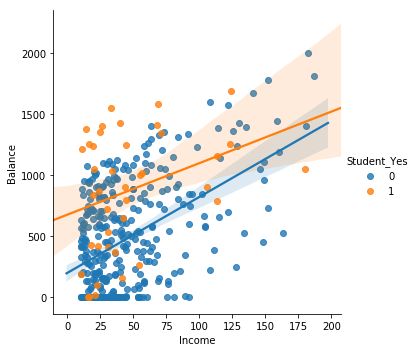

In [100]:
sns.lmplot(x="Income", y="Balance", hue="Student_Yes", data=df_final)

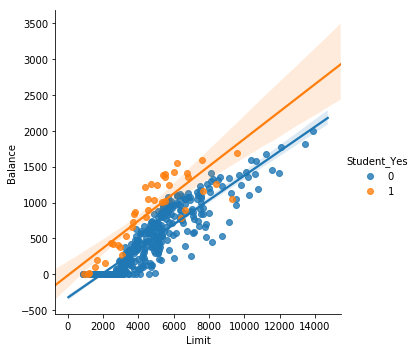

In [101]:
sns.lmplot(x="Limit", y="Balance", hue="Student_Yes", data=df_final)

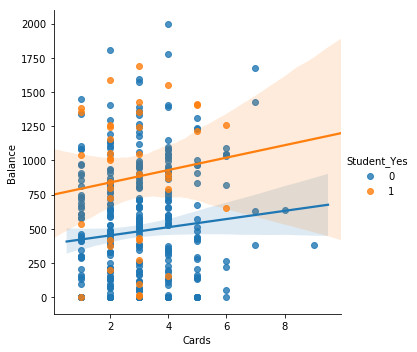

In [102]:
sns.lmplot(x="Cards", y="Balance", hue="Student_Yes", data=df_final)

En base a los gráficos, podemos ver que para los estudiantes, el Balance es superior comparado con los que no lo son.

Además, el regresor `Limit` es el que está más ajustada a la recta de la regresión.

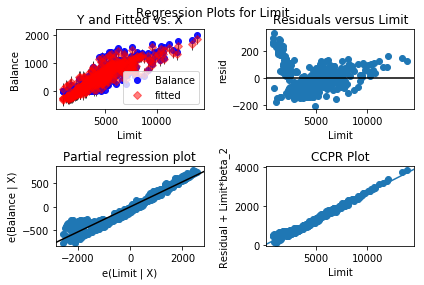

In [107]:
sm.graphics.plot_regress_exog(model5_no_rating, 'Limit');